In [1]:
# processing modules
import datetime
import glob
import json
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import random

# custom modules
import deck
import card
import user

# plotting modules
import matplotlib.pyplot as plt

# analysis modules - some may need to be installed
from sklearn.decomposition import PCA
import umap.umap_ as umap # https://umap-learn.readthedocs.io/en/latest/
import random
import hdbscan # https://hdbscan.readthedocs.io/en/latest/index.html
import scipy.stats as stats

# needed for calculation of cluster mediods
from sklearn.metrics import pairwise_distances

# Cube Map Making

Here is the code that is used to make the cube map. It requires access to CubeCobra's underlying data - to gain access to this this, ask on the Cube Cobra discord:  https://discord.gg/gDv86NP.

The data is in the json format, and this code assumes the `cubes` folder is located within `cubecobra_data` folder.

## Load the cube lists

First, we load the cube lists using a `User` class. This isn't strictly speaking correct, as a user can have multiple cubes, so really this is a class to store cubes.

This class also contains far more attributes and methods than was used to make the map - these are included for future analyses of cube decklists (that was actually what we were focused on before making the map!)

In [24]:
# load in all the cubes
cubecobra_cubes = []
for json_file in glob.glob('/Users/jettcrowdis/Documents/Miscellaneous/magic/expanded_cube_database/map_cubecobra_data/cubes/*.json'):
    with open(json_file) as in_file:
        data = json.load(in_file)
        cubecobra_cubes += data

In [25]:
user_objects = {}
cube_deck_df = []
for i, cube_data in enumerate(cubecobra_cubes):
    if i % 1000 == 0: 
        print('{}k..'.format(int(i / 1000)), end = '')
        
    # determine user id
    user_id = cube_data['id']
    
    # make user object if it doesnt exist
    if user_id not in user_objects:
        user_objects[user_id] = user.User(user_id)
    
    # update user attributes
    user_objects[user_id].last_updated = datetime.datetime.strptime(cube_data['date_updated'][:16], "%Y-%m-%dT%H:%M")
    user_objects[user_id].cube_size = len(cube_data['cards'])
    user_objects[user_id].cube_category = cube_data.get('type')
    user_objects[user_id].cube_list = cube_data['cards']
    user_objects[user_id].user = cube_data['owner_name']
    user_objects[user_id].cube_name = cube_data['name']
    user_objects[user_id].shortid = cube_data['shortID']
    user_objects[user_id].cube_image = cube_data['image_uri']
    user_objects[user_id].num_followers = len(cube_data['users_following'])
    user_objects[user_id].islisted = cube_data['isListed']
    
    cube_deck_df.append([cube_data['id'], cube_data.get('type'), cube_data['numDecks'], len(cube_data['cards']), 
                         cube_data['owner_name'], cube_data['name'], cube_data['shortID'], cube_data['image_uri'], len(cube_data['users_following'])])

0k..1k..2k..3k..4k..5k..6k..7k..8k..9k..10k..11k..12k..13k..14k..15k..16k..17k..18k..19k..20k..21k..22k..23k..24k..25k..26k..27k..28k..29k..30k..

In [26]:
cube_deck_df = pd.DataFrame(cube_deck_df, columns = ['id', 'type', 'num_decks', 'size', 'owner', 'name', 'shortid', 'image', 'num_followers'])
cube_deck_df.sort_values(by = 'num_decks', ascending = False).head(3)

,id,type,num_decks,size,owner,name,shortid,image,num_followers
11876,5d2cb3f44153591614458e5d,Legacy,26993,540,dekkerglen,MTGO Vintage Cube,3,https://img.scryfall.com/cards/art_crop/front/...,328
2408,5d61aa23b8ec593ca4b76ca6,Legacy,7731,720,wtwlf123,wtwlf123's Cube,qs,https://img.scryfall.com/cards/art_crop/front/...,307
896,5e87870a40eaf0158ee1292f,Legacy,5359,555,Zangetsukage,"MTGA Cube June 12, 2020",ar4,https://img.scryfall.com/cards/art_crop/front/...,32


Some perusing through the data has shown me that the micro cubes (the smallest cubes) tend to be around 50 cards in size. So that will be our minimum - cubes below this tend to be unfinished.

# Do some filtering

We do the following filtering:

* At least 50 unique cards
* No exact cube duplicates
* The cube needs to be listed. Currently, we don't have access to this data, so for the initial map the data was scraped (responsibly over several days) from CubeCobra. Future data releases will include listed status.

In [28]:
cube_subset = []
for cubeid, user_obj in user_objects.items():
    if 50 < len(set(user_obj.cube_list)):
        if user_obj.islisted:
            cube_subset.append(user_obj)

In [29]:
# how many cubes are in this analysis
len(cube_subset)

22707

In [30]:
# how many cards are in this analysis
card_union = set()
for user_obj in cube_subset:
    card_union.update(set(user_obj.cube_list))
    
len(card_union)

21722

# Build the cube list matrix

We only include cards that are in Scryfall and are "normal". One persistent issue is that cards with two faces are not referred to correctly by CubeCobra - Voracious Reader, for example, is present in one cube when its front side is Curious Homunculus.

There are also several instances where a card has Scryfall's "temporary" name before the card's official name is known. 

Unfortunately, we generally have to resolve these issues manually. We do so using a `cubecobra_replace_cards.json`, which maps the true scryfall name to the card in cubecobra. When we fetch cards from Scryfall, we add these mappings so that cards properly map.

In [32]:
# extract magic cards from scryfall, replacing some to match CC's formatting
# this scryfall json will need to be updated when the map is updated
magic_cards = card.fetch_cards(scryfall_url = 'https://c2.scryfall.com/file/scryfall-bulk/oracle-cards/oracle-cards-20210313220418.json', 
                               replace_json = 'ref/cubecobra_replace_cards.json', lower = True)

To handle the differing card faces, we need to map to one card face and its pair to the same index. We additionally convert to numeric indices to utilize faster matrix handling.

In [34]:
# a lookup dictionary for converting card name to numeric location, and a duplicate card dictionary to do the same for card "backsides"
card_idx_lookup = {}
duplicate_cards = {}

index = 0

# loop through all cards among cube decklists
for card in card_union:
    
    # do some filtering - some cards very weirdly have numeric indices eg "jace, miror mage 2". Cube Cobra, you wild
    if card[-1].isdigit():
        if card[-2] == ' ':
            card = card[:-2]
    
    # if it's not a magic card or it's "invalid", skip
    if card not in magic_cards or card == 'invalid card':
        continue

    # needed to skip some flip cards that are declared when their paired side is added
    if card in card_idx_lookup: 
        continue
        
    # filter out some odd cards - these are the jumpstart face cards
    if magic_cards[card].get('set') == 'fjmp':
        continue
    
    # layout is present if the card does not have a backside
    if 'layout' in magic_cards[card]:
        
        # remove emblems, tokens, and art_series. Store the card in our mapping dictionary
        if magic_cards[card]['layout'] not in ['emblem', 'token', 'art_series']:
            card_idx_lookup[card] = index
            index += 1
    
    # otherwise, we have a double faced card
    else:
        
        # see which card is on the other side
        paired_card = magic_cards[card]['name'].lower()
        
        # if the paired card is already in our lookup, map to that card
        if paired_card in card_idx_lookup:
            duplicate_cards[card] = card_idx_lookup[paired_card]
            continue
        
        # otherwise, store the new card
        else:
            duplicate_cards[card] = index
            card_idx_lookup[paired_card] = index
            index += 1
        

Now we generate the `num_cubes x num_cards` matrix that is then passed to UMAP!

In [ ]:
# create empty storage matrix
cube_list_matrix = np.zeros(shape = (len(cube_subset), len(set(card_idx_lookup.values()))))

# we loop through all the cubes present
for i, user_obj in enumerate(cube_subset):
    if i % 1000 == 0: print('{}k..'.format(i // 1000), end = '')
    
    # for each card in the cube, only store the card if it's in our valid card dictionary
    for cardname in user_obj.cube_list:
        if cardname in card_idx_lookup:
            card_idx = card_idx_lookup[cardname]
        elif cardname in duplicate_cards:
            card_idx = duplicate_cards[cardname]
        else:
            continue
        
        # if there's a valid card index, increase its entry in the matrix by 1
        # this has the effect of handling nonsingleton cubes for future use, although the way we do UMAP ignores this
        cube_list_matrix[i, card_idx] = cube_list_matrix[i, card_idx] + 1
        
# convert to a dataframe
cube_list_df = pd.DataFrame(cube_list_matrix, index = [user_obj.cubeid for user_obj in cube_subset], columns = card_idx_lookup.keys())

Now we remove duplicates.

To remove duplicates, we need to prioritize the cube with the most followers. In theory, we should do this based on cube creation date, but that's not a piece of data we currently get from Cobra.

To do this, we sort the cubes by the number of followers they have and then utilize pandas `drop_duplicates`, which by default keeps the first entry it comes across. This keeps the version of the cube with the most followers.

In [37]:
# sort cubes by followers
cubes_by_followers = cube_deck_df.sort_values('num_followers', ascending = False)['id'].values

# determine which of these cubes are actually in our matrix
cubes_by_followers_in_df = [cubeid for cubeid in cubes_by_followers if cubeid in cube_list_df.index]

# reorder the matrix based on this list
cube_list_df = cube_list_df.loc[cubes_by_followers_in_df]

In [38]:
# drop duplicates
cube_list_df_deduped = cube_list_df.drop_duplicates()

In [39]:
# export the data (this is fairly large, about 500 Mb)
cube_list_df_deduped.to_parquet('map_data/cube_data.parquet')

In [40]:
cube_list_df_deduped.shape

(21585, 21398)

So we have just under 21.5k different cubes.

# Make the map

The code below is the meat of it - the actual run of UMAP!

In [19]:
# these are the metrics that we decided on for the current iteration of the map. Subject to change.
metric = 'jaccard'
min_dist = 0.1
n_neighbors = 30
umap_random = np.random.RandomState(6) # umap is not reproducible with just integers, for some reason needs an actual random state instance

In [ ]:
# instantiate the model
umap_model = umap.UMAP(random_state = umap_random_state, min_dist = min_dist, n_neighbors = n_neighbors, metric = metric)

# fit and transform on the cube card matrix - because jaccard is used, card duplicates are ignored.
umap_result = umap_model.fit_transform(cube_list_df_deduped)

# create an exportable dataframe
umap_plot_df = pd.DataFrame(umap_result, columns = ['x', 'y'], index = cube_list_df_deduped.index)
umap_plot_df.index.name = 'cube_id'
umap_plot_df = umap_plot_df.reset_index()

# merge point locations with cube level data - followers, etc
umap_export_data = umap_plot_df.merge(cube_deck_df, left_on = 'cube_id', right_on = 'id').drop(columns = ['id'])

To help visualize the current iteration of the map (to help tweak, among other things), we manually label some cubes. These aren't meant to be particularly important or relevant, but they do give a sense for the distribution of the map.

In [ ]:
annotated_cubes = {'Anthony': '5dc09316845516168633e492',
                   'Andy': '5d39ce4b8472c42aab0b61c2',
                   'Tjornan': '5e9a38afb691a2104a7a5065',
                   'Wtwlf': '5d61aa23b8ec593ca4b76ca6',
                   'MTGO Vintage': '5d2cb3f44153591614458e5d',
                   'Arena Cube': '5ee16e234724960f53a382a6',
                   'The Pauper Cube': '5d617ac6c2a85f3b75fe95a4',
                   'mapcaster': '5d5eb696726e4277c7ba22f8',
                   'Live the Dream Cube': '5fbb269a5132cb1052b7b8b6',
                   'MTGO Legacy': '5f623ed7d7a3dc6bd7fa63f3',
                   'Proliferate Cube': '5ef2a97e86dfdc0f9579dedf',
                   'MTGO Modern': '5f836dfa437dde10abf2328e',
                   'Cultic Cube': '5e5e7c8ea0b97a386ec63124',
                   'Dekkaru Cube': '5ec5a6e77868862b1f403a41',
                   'SteveMan': '5d757b268f152803feb030f8',
                   'Funch Unpowered Fair Stuff': '5d5dc31d41c0006b8a332345',
                   'Funch Powered Fair Stuff': '5d656952d6aca45073f8b974',
                   'Build Around': '5eee24d7c12c5572693d1c28',
                   'SCGCon Powered': '5d710ed230f3075de517bfd5',
                   'Old Border Pauper': '5d753dd88f152803feae83a1',
                   'Graveyard Cube': '5dc2c59bb763fe4753dfdb95',
                   'Ravnica Cube': '5e4ad7267c58b65e51bc4e5c',
                   'Un Cube': '5f7b08c4debf310362e017d3',
                   'Desert Cube': '5e57dbdf60257e28d4e340ec',
                   'Multicolor Cube': '5e137f288fcd650c405ea77f',
                   'Peasant Cube': '5d5f69612af66a30f9bb9b10',
                   'Old Border': '5ed16b287b7511525c0ca115',
                   'Modern Peasant/Pauper/Budget': '5e086b70c1a6d7453621bc00',
                   'Historic Peasant': '5e8d4f0597968b319ceb1a6e',
                   'Pauper+ (No Bans)': '5e30c1ace47df8620122a334',
                   'Innistrad': '5d8d292a884bf534916603d7',
                   'Horror/Innistrad': '5d8b6ae550a8152674ab26c4',
                   'Synergy Cubes': '5d34f0075e640548ccf76c59',
                   'Card Kingdom Starter': '5e714c737d65df45f5f3558b',
                   'Zolthux': '5d2d21d11e75ae17bbd573f3',
                   'Queenscat': '5d6ecd8cc22ed62d2793f50e', 
                   'Miscellaneous': '5e928f41df3ffb74934ee2f3',
                   'DMC': '5eac352663be2427d677d971',
                   'Sanderson CC': '5dd03ec2d6b9480bc3fe7293',
                   'Funchalot Fair': '5e00d06ce2a67c472c0c84db',
                   'Caleb Gannon': '5fab13510efe0d1071b87fae',
                   'Cultic Eleusis': '5d4c6fcd97ca265764f29fa4',
                   'Conspiracy Cube': '5d9504ccbf1a21083944f035',
                   '2HG': '5edc9a42f3c0f00f5e77a698',
                   'EDH': '5d8978207836a91c43c8e3cf',
                   'cEDH': '5db1bb76a4e3bf6a514c47d0',
                   'B&R': '5f28d91d558f22103da78933',
                   'Grixis': '5e88d286af77b243a6a05a0f',
                   'MonoU': '5d76f167781ceb1042c03bff',
                   'Temur': '5ffe2f6b8e97c010837ff51d',
                   'MonoB': '5e5a8df19a68a543f7611d4c',
                   'GY': '5ea243f209bbf1105ec21b09',
                   'Mengu': '5fbfe8438d49862caf6a36dc',
                   'Simpleman': '5d5edb04726e4277c7bb31be',
                   'Pioneer': '5dbce1d4558eb45ea1f52eb7',
                   'Arena': '5f3e8c827440640ffe679a5e',
                   'Historic': "5ee16e234724960f53a382a6",
                   'Amaz': '5ed29a43d44a3c102e14500a', 
                   'Battlebox': '5f8d1ecb854582104384177f',
                   'OG Ravnica': '5dbb28f0c67d7070936a5e4f',
                   'Eldraine': '5e878c116f01105bb05f8b79',
                   'MTGO Core': '5fb92dab0895aa0fc022f8aa',
                   'Players Cube': '5d710f7130f3075de517c00b',
                   'Cthulhu': '5d5ef816726e4277c7bbc6be',
                   'Strictly Worse': '5d8171de91139f32f85d1200',
                   'MH1': '5f51d323c63a006cfe1d5967',
                   'Tribal': '5d34989cd0c53f45e921af7b',
                   'Devoid': '5dc9a64553f3101ce8e1d08c',
                   'Multicolor': '5fae85ff8459ff65ae3572c3', 
                   'Lands': '5db379a817987c7fd2f63c79',
                   'Duplicates': '5ecbfae65d940f100d33b989',
                   'Judges Tower': '5d9a3ae0a91a525ceaa2e3d5',
                   'One Drop Cube': '5fe91c7e5704310fcac186a4'}

We plot these cubes here:

/Users/jettcrowdis/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1530: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


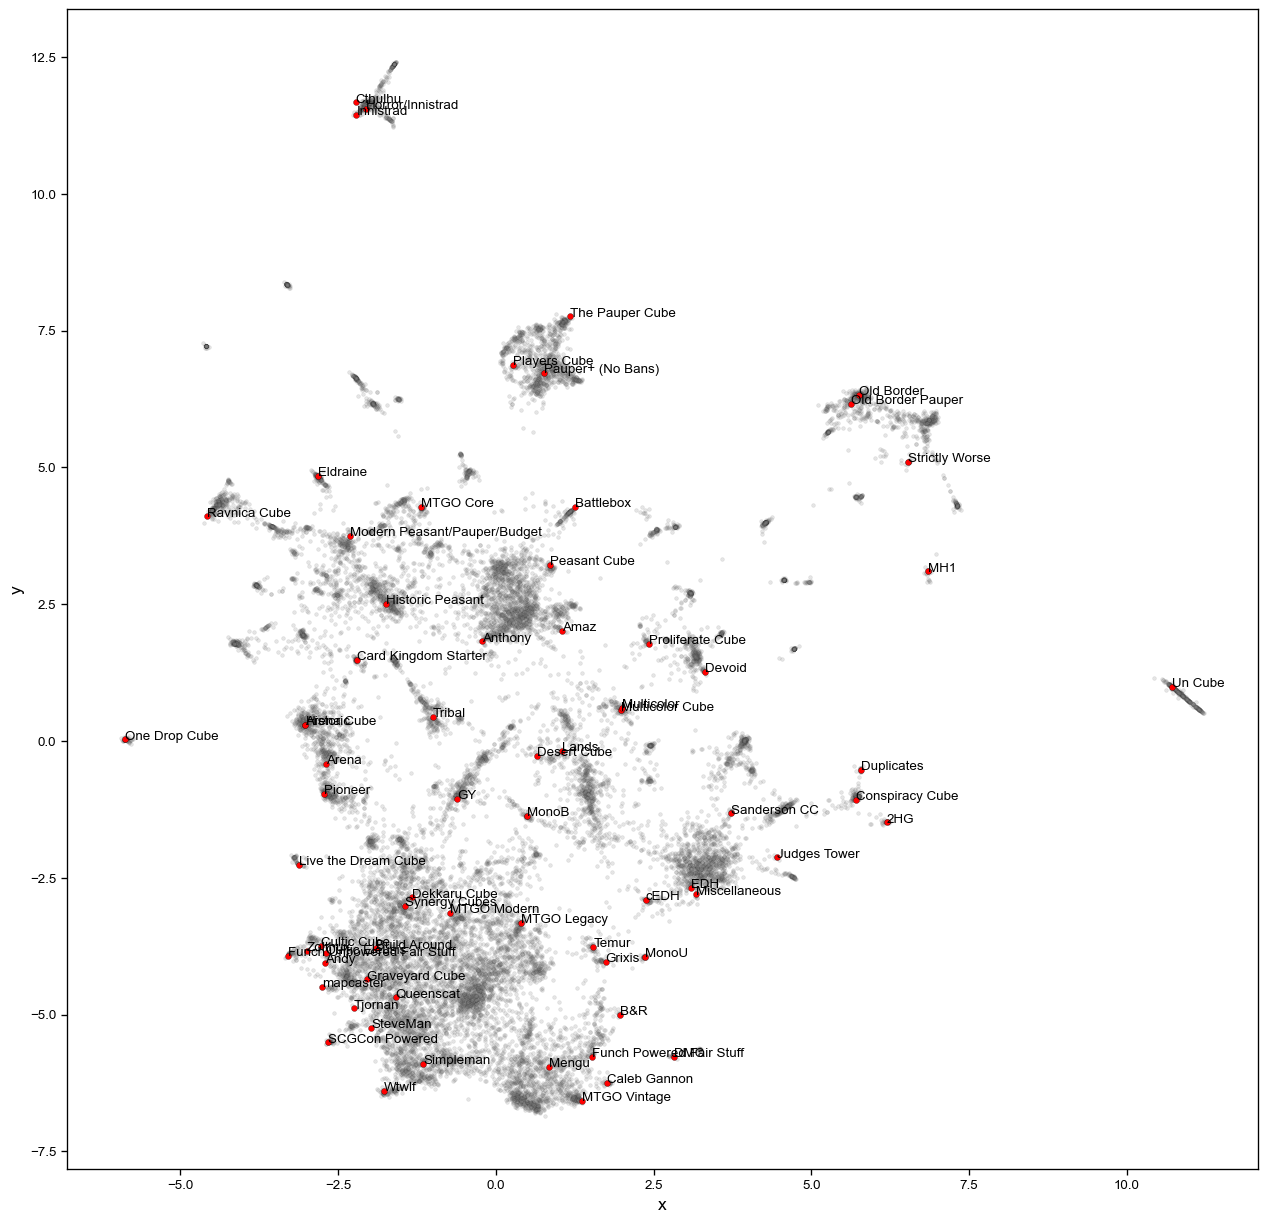

In [20]:
fig, ax = plt.subplots(1, figsize = (16, 16))
sns.scatterplot(x = 'x', y = 'y', data = umap_plot_df,
                ax = ax, edgecolor = 'black', linewidth = 0.2, s = 8, color = 'grey', alpha = 0.2)

for cube, cubeid in annotated_cubes.items():
    if cubeid not in umap_plot_df['cube_id'].to_list(): continue
    umap_data = umap_plot_df.set_index('cube_id').loc[[cubeid]]
    sns.scatterplot(data = umap_data, x = 'x', y = 'y', ax = ax, label = '', s = 20, 
                    edgecolor = 'black', linewidth = 0.2, color = 'red')

    umap_x, umap_y = umap_data[['x', 'y']].values[0]

    ax.text(x = umap_x, y = umap_y, s = cube, color = 'black', fontsize = 10)

Notably, the site reflects this on the y axis so that the main landmass is at the top.

# HDBSCAN Clustering

To cluster these outputs, we run HDBSCAN on the results from UMAP

HDBSCAN has some excellent documentation: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html  
UMAP also recommends HDBSCAN for clustering on its outputs: https://umap-learn.readthedocs.io/en/latest/clustering.html

HDBSCAN doesn't handle large datasets very well, so we'll use UMAP to reduce dimensionality down to n = 6. This was determined after some fiddling - higher number of dimensions spreads out the map too much, and lower dimensions causes clumping. Notably, the documentation for UMAP/HDBSCAN clustering says that we should use different parameters than those used for visualization. Notably, we should increase n_neighbors to avoid clustering on noise, and we should decrease min_dist because we want our clusters to be tightly packed.

I have discovered that increasing `n_neighbors` causes several large landmass clusters to be all grouped together (e.g. all the Pauper cubes together).

After much fiddling, I settled on the following parameters:

In [ ]:
hdbscan_min_dist = 0 # This is recommended by UMAP  
hdbscan_n_components = 6 # Any lower, and you start to get fuzziness in clustering. Any higher, and smaller clusters start merging together.  
hdbscan_n_neighbors = 20 # Any higher, and the pauper cluster is declared as one cluster. Lower, and it starts to be fuzzy.  
hdbscan_random_state = np.random.RandomState(8) # At least for this iteration of data, results in proper splitting of larger Pauper and Peasant landmasses.

In [ ]:
# instantiate the UMAP model
hdbscan_umap_model = umap.UMAP(n_neighbors = hdbscan_n_neighbors, min_dist = hdbscan_min_dist, n_components = hdbscan_n_components, 
                               random_state = hdbscan_random_state, metric = 'jaccard')

# fit the model on our cube data
clusterable_embedding = hdbscan_umap_model.fit_transform(cube_list_df_deduped.values)

Now we run HDBSCAN on this clusterable UMAP output

We use the following parameters. I chose these to preserve small clusters - some clear clusters (e.g. bear cubes) have as few as 6 cubes. Generating prediction data and the spanning tree is necessary to do forced predictions later.

For some reason, HDBSCAN will tend to have memory issues unless `min_samples` is explicitly set? Despite its default being the same as `min_cluster_size`. 

In [ ]:
# instantiate the HDBSCAN model
clusterer = hdbscan.HDBSCAN(min_cluster_size = 6, min_samples = 6, prediction_data=True, gen_min_span_tree = True, core_dist_n_jobs = 1)

# now we classify cubes!
labels = clusterer.fit_predict(clusterable_embedding)

/Users/jettcrowdis/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1530: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


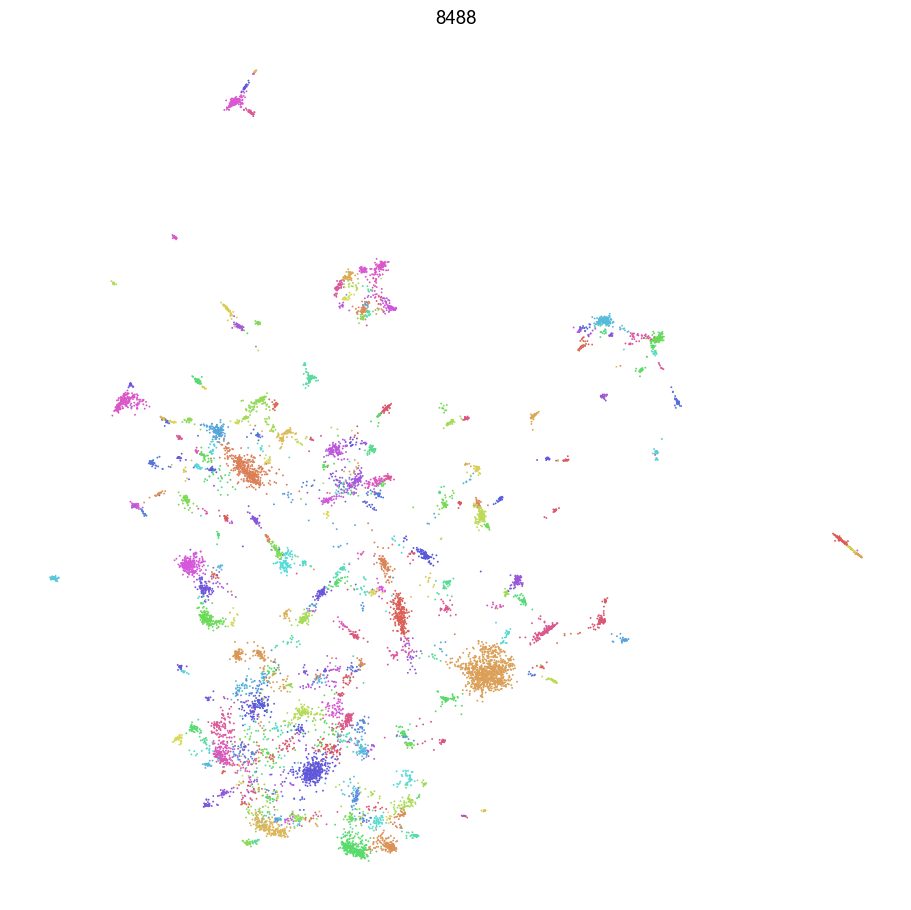

In [22]:
# we add these cluster labels to our umap data. The clustering is "soft" because many cubes are not classified.
umap_export_data['soft_cluster'] = labels

# assign random colors to clusters
hls = sns.color_palette("hls", np.max(labels) + 1)
random.shuffle(hls)
palette = dict(zip(range(len(hls)), hls))
palette[-1] = 'grey'

# now we plot! only the cubes that are assigned
fig, ax = plt.subplots(1, figsize = (12, 12))
sns.scatterplot(x = 'x', y = 'y', data = umap_export_data[umap_export_data['soft_cluster'] != -1], s = 2, 
                ec = None, hue = 'soft_cluster', palette = palette)
ax.legend().remove()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
sns.despine(left = True, bottom = True)

# label how many cubes haven't been assigned
num_negative_one = cluster_info['number'].iloc[0]
ax.set_title(f'{num_negative_one} unassigned');

So this actually works reasonably well, but HDBSCAN chooses to not assign many many cubes. This is somewhat understandable, as the data is so complicated, and particularly the region with unpowered cubes is low density and amorphous.

We can force HDBSCAN to make classifications

In [23]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

# we assign these new clusters. I haven't actually checked if the clusters remain the same
umap_export_data['cluster'] = np.argmax(soft_clusters, axis = 1)

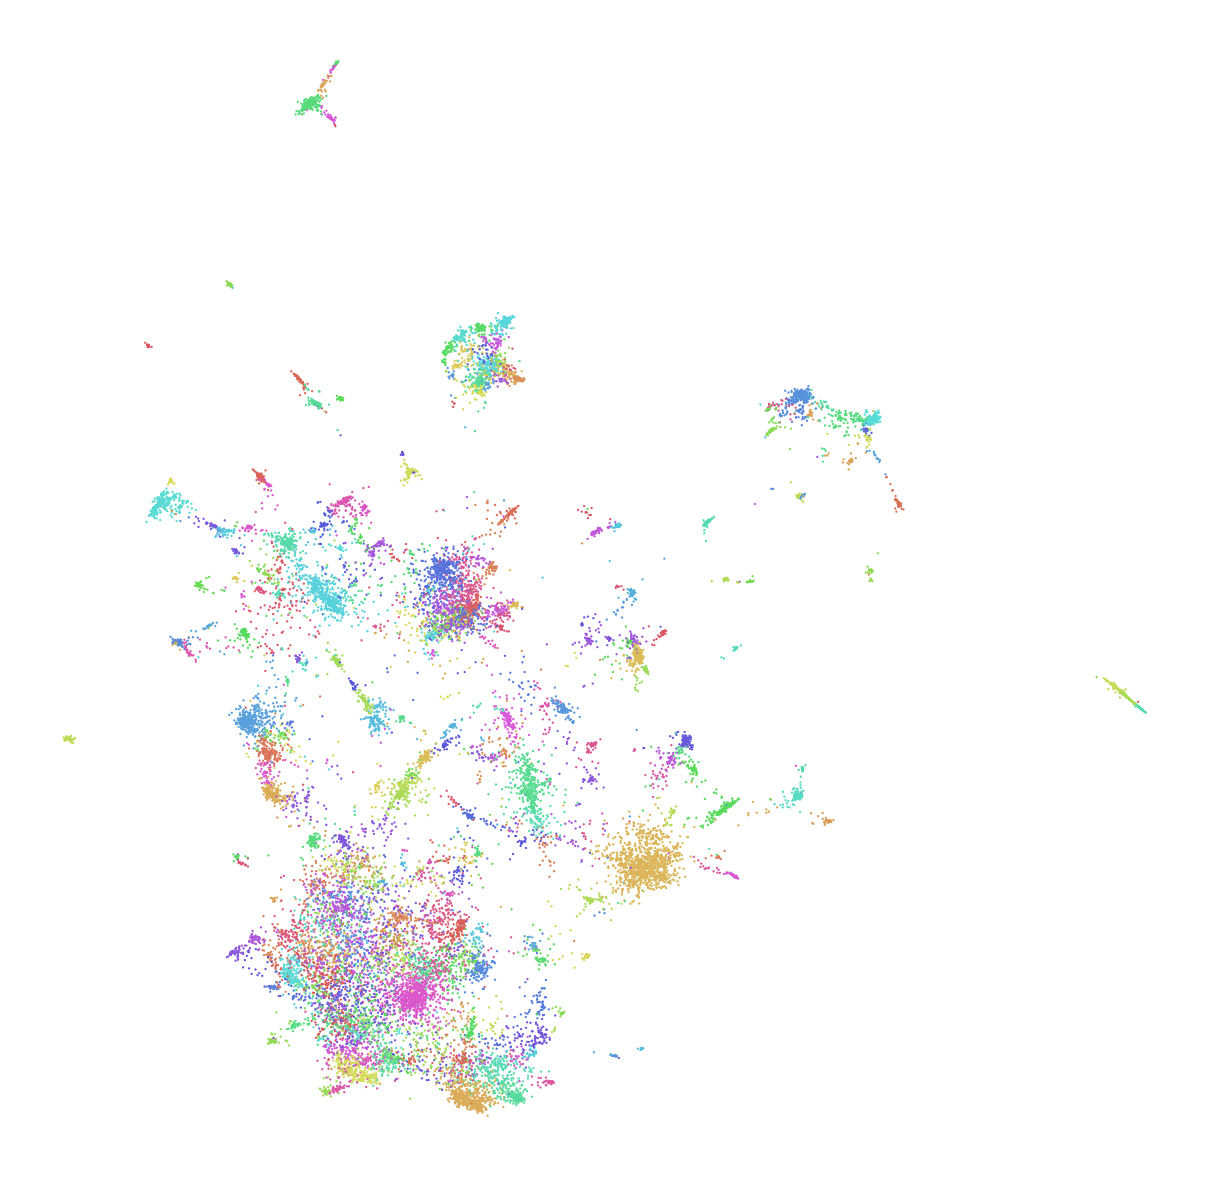

In [24]:
hls = sns.color_palette("hls", np.max(labels) + 1)
random.shuffle(hls)
palette = dict(zip(range(len(hls)), hls))
palette[-1] = 'grey'

fig, ax = plt.subplots(1, figsize = (16, 16))
sns.scatterplot(x = 'x', y = 'y', data = umap_export_data, s = 3, ec = None, hue = 'cluster', palette = palette)
ax.legend().remove()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
sns.despine(left = True, bottom = True)

We shuffle the clusters to prevent the colors on the map from being similar colors in clusters close to each other

In [30]:
np.random.seed(0)
old_clusters = range(umap_export_data['cluster'].max() + 1)
new_clusters = list(old_clusters)
np.random.shuffle(new_clusters)
shuffle_dict = dict(zip(old_clusters, new_clusters))

In [32]:
# shuffle clusters
umap_export_data['cluster'] = umap_export_data['cluster'].replace(shuffle_dict)

We reformat the data for the way the site handles the data.

In [40]:
# reformat some fields - truncate digits to decrease data size
umap_export_data[['x', 'y']] = umap_export_data[['x', 'y']].round(4)
cube_map_data = umap_export_data[['shortid', 'x', 'y', 'size', 'owner', 'name', 'image', 'num_followers', 'cluster']].copy()

# remove doubling cube images - they will render by default
doubling_cubes = ['https://img.scryfall.com/cards/art_crop/front/3/d/3d946df5-f206-4241-bb55-97db67dc793c.jpg?1562546549',
                  'https://c1.scryfall.com/file/scryfall-cards/art_crop/front/2/2/220d3a38-10f8-4d4a-84b8-f17b10a2cd6c.jpg?1562875845',
                  'https://img.scryfall.com/cards/art_crop/front/2/2/220d3a38-10f8-4d4a-84b8-f17b10a2cd6c.jpg?1562875845']

doubling_cube_rows = cube_map_data[cube_map_data['image'].isin(doubling_cubes)].index
cube_map_data.loc[doubling_cube_rows, 'image'] = ''

# rename columns and export data
cube_map_data.columns = ['cube_id', 'x', 'y', 'size', 'owner', 'name', 'image', 'num_followers', 'cluster']

In [36]:
# data for the site
cube_map_data.to_csv('map_data/cube-map.csv', index = False)

In [39]:
# the full data
umap_export_data.to_csv('map_data/full-cube-map-data.csv', index = False)

# Examine cluster defining cards

We examine individual clusters to find the cards that define them. For more information on the logic behind this, visit https://luckypaper.co/articles/mapping-the-cube-landscape/#cluster-defining-cards

First, we group cubes together by cluster and calculate the counts of each card within each cluster. The result of this process is a `num_cluster x n_cards` matrix that will form the basis for how we do the fisher's exact test.

In [43]:
# first, for each cluster we sum the cards in those decks. We convert to binary because fisher's exact won't work otherwise
cube_data_binary = cube_list_df_deduped > 0
cluster_card_df = pd.DataFrame(index = range(umap_export_data['cluster'].max()), columns = ['size'] + list(cube_data_binary.columns))

# for each cluster, calculate the card counts
for clust in range(umap_export_data['cluster'].max()):
    print(clust, end = ', ')
    cluster_cubes = umap_export_data[umap_export_data['cluster'] == clust]['cube_id']

    # add together the counts in all the decks
    num_decks = cluster_cubes.shape[0]
    cluster_card_counts = cube_data_binary.loc[cluster_cubes].sum(axis = 0)

    # store in matrix
    cluster_card_df.loc[clust, :] = [num_decks] + list(cluster_card_counts)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

# Now, compare clusters to each other

The fisher's exact test works by comparing two clusters with each other. Notably, we have to do this test _directionally_, which means that the results of A vs. B are not the same as B vs. A (this is because for a given cluster, we ONLY want cards enriched in that cluster). For you stats folks, this means that we do a _one sided_ Fisher's exact test.

For each cluster, we identify the top 300 cards in the cluster. Within these cards, we calculate the fisher's exact test p value for that cluster and card compared to all other clusters. It would be great to analyze ALL cards for each cluster, but that is computationally intractable. In theory, a card might not be within the top 300 cards and still be among the most enriching - I have found this is vanishingly rare.

Even only considering the top 300, this code takes an extraordinarily long time to run (several hours). 

In [54]:
# how many cards to examine
n = 300

# we loop through each cluster
for cluster, row in cluster_card_df.iterrows():

    print(cluster, end = ', ')

    # determine cluster size and cards in the cluster
    cluster_size = row[0]
    cards = row[1:]

    # only examine cards above filter - the top n cards
    represented_counts = cards.sort_values(ascending = False)[:n]
    represented_counts = represented_counts[represented_counts > 0]
    represented_cards = represented_counts.index

    # for each other cluster, do a pairwise fishers exact test for each card.
    other_clusters = np.delete(np.arange(len(cluster_card_df)), cluster)
    
    # store results of fisher's exact tests
    cluster_significance_df = []
    
    # loop through all other clusters
    for other_clust in other_clusters:
        other_clust_row = cluster_card_df.loc[other_clust]
        other_clust_size = other_clust_row[0]
        other_clust_cards = other_clust_row[1:]

        # get the counts for the current card in the other cluster
        other_represented_counts = other_clust_cards[represented_cards]

        # for each card, perform the fisher's exact test. We form a contigency table
        for card in represented_counts.index:
            card_count_cluster = represented_counts.loc[card]
            card_count_outcluster = other_represented_counts.loc[card]

            cont_table = [[card_count_cluster, cluster_size - card_count_cluster],
                          [card_count_outcluster, other_clust_size - card_count_outcluster]]
        
            # run the fisher's exact and append the results
            odds, p = stats.fisher_exact(cont_table, alternative = 'greater')
            cluster_significance_df.append([cluster, other_clust, card, odds, p])
    
    # gather up all the cluster information and export it. -logp is used because it is easier to store and "ascends" for more enriched cards as we expect
    cluster_significance_df_out = pd.DataFrame(cluster_significance_df, columns = ['cluster', 'other_cluster', 'card', 'odds', 'p'])
    cluster_significance_df_out['-logp'] = (-np.log(cluster_significance_df_out['p'])/np.log(10)).round(3)
    cluster_significance_df_out[['cluster', 'other_cluster', 'card', '-logp']].to_csv(f'cluster_comparisons/updated_{cluster}.tsv', sep = '\t', index = False)


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

# Generate global and local cards

So the above block of code results in a file for each cluster. That file contains comparison results for each other cluster for each card. We take the median `-logp` value for each card across all other clusters.

For globally defining cards, we take the median across all other clusters. For locally defining cards, we take the median across the 15 closest cluster (with closeness defined as distance between mediods)

In [56]:
# calculate the locations of the mediods and then create a distance matrix between clusters in 2D space. We use this to find the closest clusters
mediods = umap_export_data.groupby('cluster')[['x', 'y']].median()

# make distance matrix
distances = pd.DataFrame(pairwise_distances(mediods.values), index = mediods.index, columns = mediods.index)

In [57]:
# extract the top 20 cards for each cube globally and the top 20 locally enriching cards
defining_cards = []

for cluster in range(len(set(umap_export_data['cluster'])) - 1):

    print(cluster, end = ', ')
    
    # read in the cluster data from the exported file
    cluster_data = pd.read_csv(f'cluster_comparisons/updated_{cluster}.tsv', sep = '\t')
    
    # identify the nearest 15 clusters (0 index is the cluster itself)
    closest_clusters = [other_clust for other_clust in distances.loc[cluster].sort_values().index[1:16]]
    
    # group by the card and take the median -logp across all other clusters for globally defining cards
    top_cards = pd.DataFrame(cluster_data.groupby(['cluster', 'card'])['-logp'].median()).reset_index().sort_values(by = '-logp', ascending = False).head(20).round(1).reset_index()
    
    # take only the data for the 15 closest clusters and repeat for locally defining cards
    closest_cluster_data = cluster_data[cluster_data['other_cluster'].isin(closest_clusters)]
    top_closest_cards = pd.DataFrame(closest_cluster_data.groupby(['cluster', 'card'])['-logp'].median()).reset_index().sort_values(by = '-logp', ascending = False).head(20).round(1).reset_index()
    
    # combine local and global defining cards. We only want specific columns - cluster, globally defining cards, and locally defining cards
    combined_cards = pd.concat([top_cards, top_closest_cards], axis = 1)
    combined_cards = combined_cards.iloc[:, [1, 2, 6]]
    combined_cards.columns = ['cluster', 'globally_defining', 'locally_defining']
    
    # append to our storage list
    defining_cards.append(combined_cards)

# convert to dataframe
defining_cards = pd.concat(defining_cards).reset_index(drop = True)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

## Make card names uppercase

For the map, card names need to be properly cased. Cube Cobra stores all their card names in a lowercase version. We use scryfall to convert back.

In [146]:
upper_magic_cards = card.fetch_cards(scryfall_url = 'https://c2.scryfall.com/file/scryfall-bulk/oracle-cards/oracle-cards-20210313220418.json', 
                               replace_json = 'ref/cubecobra_replace_cards.json', lower = False)

In [147]:
lower_upper_mapping = {card.lower(): card for card in upper_magic_cards.keys()}

In [148]:
# quickly check that all cards are in this mapping
set(np.ravel(defining_cards[['globally_defining', 'locally_defining']].values)) - set(lower_upper_mapping.keys())

set()

In [149]:
uppercase_defining_cards = defining_cards.replace(lower_upper_mapping)

In [151]:
uppercase_defining_cards.to_csv('map_data/cube-map-clusters.csv', index = False)

# Run PCA

We need PCA level results for the article. See https://luckypaper.co/articles/mapping-the-cube-landscape/#pca

In [43]:
cube_data_binary = cube_list_df_deduped > 0

In [44]:
pca_model = PCA(n_components = 2)
pca_result = pca_model.fit_transform(cube_data_binary)
pca_df = pd.DataFrame(pca_result, columns = ['PCA_{}'.format(i + 1) for i in range(2)],
                      index = cube_data_binary.index)

(-8.0, 22.0)

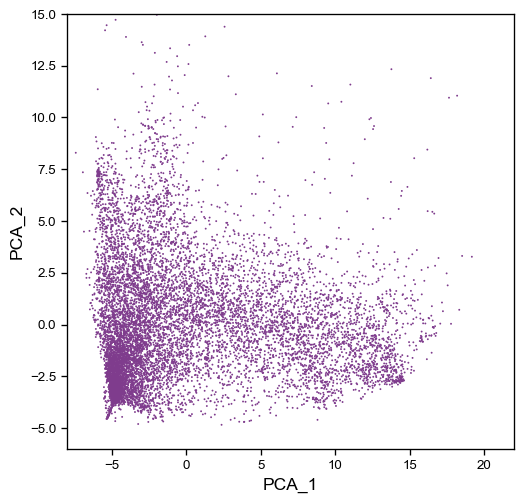

In [47]:
sns.scatterplot(x = 'PCA_1', y = 'PCA_2', data = pca_df.sample(frac = 0.5, replace = False, random_state = 0), s = 2, ec = None)
plt.ylim([-6, 15])
plt.xlim([-8, 22])

In [50]:
# export data for article
pca_export = pca_df.sample(frac = 0.5, replace = False, random_state = 0).round(4)
pca_export = pca_export[(pca_export['PCA_1'].between(-8, 22)) & (pca_export['PCA_2'].between(-6, 15))]
pca_export.to_csv('map_data/pca-sampled-data.csv', index = False, header = False)

In [153]:
# determine components
components = pd.DataFrame(pca_model.components_[:2, :].T, columns=['PC1', 'PC2'], index = cube_data_binary.columns)
pc1 = (components.sort_values(by = 'PC1', ascending = False)*100).reset_index()
pc2 = (components.sort_values(by = 'PC2', ascending = False)*100).reset_index()

# uncommenting the below code will show the PCA components for cards
# pd.concat([pc1.head(40), pc1.tail(40)])
# pd.concat([pc2.head(40), pc2.tail(40)])